# playing with QuadTree + Triangles
segment the cells with triangles... is this more useful?

**conclusion:** It's certainly fun, but seems like using K-D Tree approach +  a proper triangular mesh is a more robust approach if we're going to chase complexity here

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from qthist2d import qthist, qtcount


In [100]:
# here's a triangular mesh idea:
# for the final QuadTree, try sub-dividing every cell into triangles
# for simplicity, try just splitting once (either top left to bottom right, or bottom left to top right)
# keep which ever is "better"... but what is better?
#    either: divides sample most evenly, or divides most strongly,
#        or maximizes entropy (max distance between weighted center of each cell)

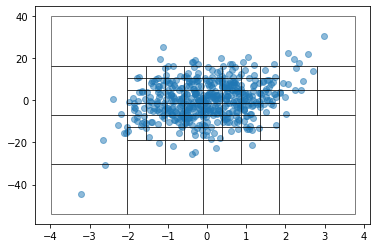

In [368]:
Npts = 500
x = np.random.normal(size=Npts)
y =  x**3 + (8 * np.random.normal(size=Npts))
# y = np.random.normal(size=Npts)

num, xmin, xmax, ymin, ymax = qthist(x,y, N=4, thresh=10, density=False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y, alpha=0.5)

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc ='none', ec='k', alpha=0.5))

In [369]:
num2 = np.array([])
area2 = np.array([])

for l in range(len(num)):
    m1 = (ymax[l] - ymin[l]) / (xmax[l] - xmin[l])
    b1 = ymin[l] - m1 * xmin[l]

    if num[l] > 0:
        t1 = ((x >= xmin[l]) & (y >= ymin[l]) & 
              (x < xmax[l]) & (y < ymax[l]) & 
              (y > m1*x+b1))
        t2 = ((x >= xmin[l]) & (y >= ymin[l]) & 
              (x < xmax[l]) & (y < ymax[l]) & 
              (y <= m1*x+b1))
        
        m2 = (ymax[l] - ymin[l]) / (xmin[l] - xmax[l])
        b2 = ymax[l] - m2 * xmin[l]

        t3 = ((x >= xmin[l]) & (y >= ymin[l]) & 
              (x < xmax[l]) & (y < ymax[l]) & 
              (y < m2*x+b2))

        t4 = ((x >= xmin[l]) & (y >= ymin[l]) & 
              (x < xmax[l]) & (y < ymax[l]) & 
              (y >= m2*x+b2))
        
    pick = 1
    # ideally we want triangles that maximally separate the sample
    if (num[l] > 0) & (np.abs(sum(t1)-sum(t2)) < np.abs(sum(t3)-sum(t4))):        
        pick=2
    
    if (num[l] > 0) & (np.abs(sum(t1)-sum(t2)) == np.abs(sum(t3)-sum(t4))):
            xcent1 = (xmin[l] + xmin[l] + xmax[l])/3.
            xcent2 = (xmin[l] + xmax[l] + xmax[l])/3.
            ycent1 = (ymax[l] + ymax[l] + ymin[l])/3.
            ycent2 = (ymax[l] + ymin[l] + ymin[l])/3.

            xt1 = xcent1
            xt2 = xcent2
            yt1 = ycent1
            yt2 = ycent2
            
            xt3 = xcent1
            xt4 = xcent2
            yt3 = ycent2
            yt4 = ycent1

            if sum(t1) > 0:
                xt1 = x[t1].mean()
                yt1 = y[t1].mean()
            if sum(t2) > 0:
                xt2 = x[t2].mean()
                yt2 = y[t2].mean()

            if sum(t3) > 0:
                xt3 = x[t3].mean()
                yt3 = y[t3].mean()
            if sum(t4) > 0:
                xt4 = x[t4].mean()
                yt4 = y[t4].mean()

            c_dist1 = (np.sqrt((xt1 - xcent1)**2 + (yt1 - ycent1)**2) + 
                       np.sqrt((xt2 - xcent2)**2 + (yt2 - ycent2)**2))
            c_dist2 = (np.sqrt((xt3 - xcent1)**2 + (yt3 - ycent2)**2) + 
                       np.sqrt((xt4 - xcent2)**2 + (yt4 - ycent1)**2))
            
            if c_dist2 < c_dist1:
                pick = 2

    area_l = [(xmax[l]-xmin[l])*(ymax[l]-ymin[l])/2, 
              (xmax[l]-xmin[l])*(ymax[l]-ymin[l])/2]
    area2 = np.append(area2, area_l)
    
    if pick == 1:
#         plt.plot([xmin[l], xmax[l]], m1*np.array([xmin[l], xmax[l]]) + b1, c='r', alpha=.5)
        tri1 = [[xmin[l],ymin[l]],[xmin[l],ymax[l]],[xmax[l],ymax[l]]]
        tri2 = [[xmin[l],ymin[l]],[xmax[l],ymin[l]],[xmax[l],ymax[l]]]
        num2 = np.append(num2, [sum(t1), sum(t2)])
        
    if pick == 2:
#         plt.plot([xmin[l], xmax[l]], m2*np.array([xmin[l], xmax[l]]) + b2, c='k', alpha=.5)
        tri1 = [[xmin[l],ymax[l]],[xmax[l],ymin[l]], [xmin[l],ymin[l]]]
        tri2 = [[xmin[l],ymax[l]],[xmax[l],ymin[l]], [xmax[l],ymax[l]]]
        num2 = np.append(num2, [sum(t3), sum(t4)])

    if l==0:
        poly = tri1
    if l>0:
        poly = np.dstack((poly, tri1))
    poly = np.dstack((poly, tri2))


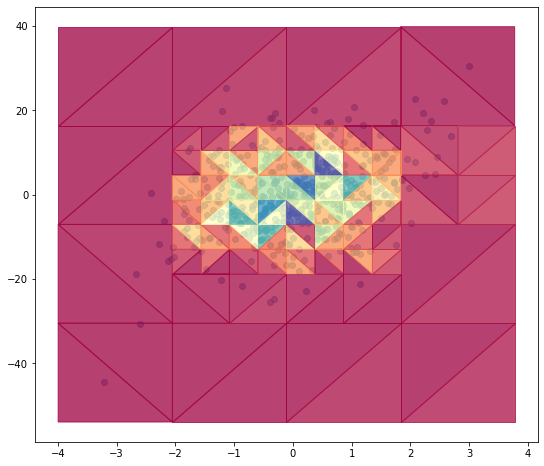

In [370]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
plt.scatter(x,y, alpha=0.5)

CMAP = plt.cm.Spectral
SCORE = (num2/num2.sum()/area2)
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))

for l in range(len(num2)):
    ax.add_patch(plt.Polygon(poly[:,:,l], closed=True,fill=True, color=CMAP(clr[l]), alpha=0.75)) 
#     ax.add_patch(plt.Polygon(tri2, closed=True,fill=True, color=clr, alpha=0.25))

In [280]:
test = np.array([1,2,3])
test = np.vstack((test, test))
test.shape

(2, 3)

In [254]:

#             c_dist1 = np.sqrt((xt1 - xt2)**2 + (yt1 - yt2)**2)
#             c_dist2 = np.sqrt((xt3 - xt4)**2 + (yt3 - yt4)**2)
#             if c_dist2 < c_dist1:
#                 pick=2
                
#             print(l, xt1 - xcent1,yt1 - ycent1,xt2 - xcent2,yt2 - ycent2, c_dist1)
#             print(l, xt3 - xcent1,yt3 - ycent2,xt4 - xcent2,yt4 - ycent1, c_dist2)



In [4]:
# here's a voronoi idea:
# for each final cell, compute the center (mean position)
#    this could be done in the inital loop inside QT Hist
# use those centers as the nodes for a normal voronoi diagram
# draw it!
# can we get back the objects per cell (the might be slightly different)
#     need to compute per cell: counts, density,

In [6]:
# you can also use the density keyword to measure the probability density of sources,
# very comprable to a normal histogram2d
num, xmin, xmax, ymin, ymax = qthist(x,y, N=5, thresh=4, density=True)

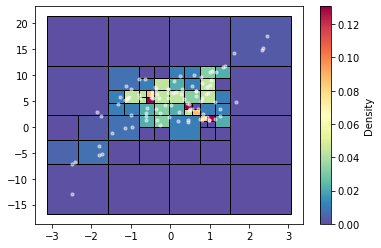

In [7]:
fig = plt.figure()

ax = fig.add_subplot(111)

CMAP = plt.cm.Spectral_r

clr = (num - np.nanmin(num)) / (np.nanmax(num) - np.nanmin(num))

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc =CMAP(clr[k]), ec='k', alpha=1))

# create a fake image, just to invoke colormap
img = plt.imshow(np.array([[0,1]]), cmap=CMAP, aspect='auto',origin='lower', 
                 vmin=num.min(),vmax=num.max()) # scale to the density
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('Density')

plt.scatter(x,y,  c='w', alpha=0.5, zorder=2, s=10)


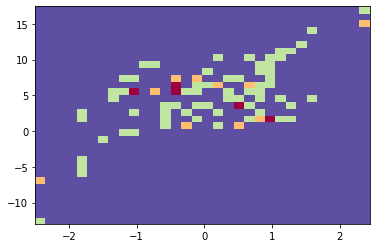

In [13]:
# for comparison, here is a normal histogram at the smallest scale used for the QuadTree Hist
_ = plt.hist2d(x,y, bins = 2**5, cmap=plt.cm.Spectral_r)

In [8]:
# you can also use the existing grid to e.g. count the density of another set of (x,y) data in these bins

Npts = 100
x2 = np.random.normal(size=Npts) + 1
y2 = -np.random.random(size=Npts)*10 + x**2

num2 = qtcount(x2, y2, xmin, xmax, ymin, ymax, density=True)

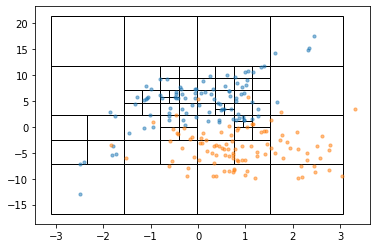

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

CMAP = plt.cm.Spectral_r
clr = (num2 - np.nanmin(num2)) / (np.nanmax(num2) - np.nanmin(num2))

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc ='none', ec='k', alpha=1))

plt.scatter(x,y,  c='C0', alpha=0.5, zorder=2, s=10)
plt.scatter(x2,y2,  c='C1', alpha=0.5, zorder=2, s=10)



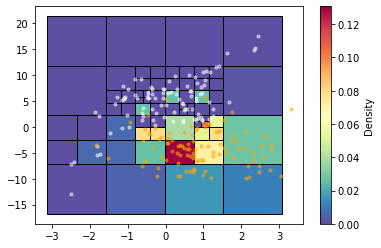

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

CMAP = plt.cm.Spectral_r
clr = (num2 - np.nanmin(num2)) / (np.nanmax(num2) - np.nanmin(num2))

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc =CMAP(clr[k]), ec='k', alpha=1))

# create a fake image, just to invoke colormap
img = plt.imshow(np.array([[0,1]]), cmap=CMAP, aspect='auto',origin='lower', 
                 vmin=num.min(),vmax=num.max()) # scale to the density
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('Density')


plt.scatter(x,y,  c='w', alpha=0.5, zorder=2, s=10)
plt.scatter(x2,y2,  c='orange', alpha=0.5, zorder=2, s=10)


In [ ]:
# note the bins were set to contain all data in the first dataset,
# so if the new data fall outside the bins, it doesn't get counted
# just like in a normal histogram